# Objective 
Evaluate all calibrated ensemble outputs

In [5]:
import glob,os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [119]:
outdir = '/glade/p/work/manab/ff/islandpark/output/allens'
prms = sorted(glob.glob(outdir + '/*_111_runs_best*.nc'))
hechms = sorted(glob.glob(outdir + '/*_222_runs_best*.nc'))
vic = sorted(glob.glob(outdir + '/*_333_runs_best*.nc'))
sacsma = sorted(glob.glob(outdir + '/*_444_runs_best*.nc'))

In [161]:
def qextract(nclist):
    '''
    Extracts q from each ensemble and concatenates them 
    into a single array
    '''
    ncdat = np.empty([37,])
    for count, value in enumerate(nclist):
        ncout = xr.open_dataset(value)
        ncout = ncout.groupby('time.year').max()
        ncout = ncout.where((ncout.year > 1979), drop = True)
        q = ncout['q_routed'].values
        ncdat = np.c_[ncdat, q]
    ncdat = np.delete(ncdat,(0), axis=1)
    return(ncdat)

In [175]:
# Prepare simulation data
prmsq = qextract(prms)
hechmsq = qextract(hechms)
vicq = qextract(vic)
sacsmaq = qextract(sacsma)

KeyboardInterrupt: 

In [185]:
# Prepare mean ensemble data
meanqdat = prmsq.mean(axis=1)

In [186]:
# Prepare observation data 
ncout = xr.open_dataset(prms[1])
ncout = ncout.groupby('time.year').max()
ncout = ncout.where((ncout.year > 1979), drop = True)
qobs = ncout['obsq'].values

# FLOW DURATION CURVES

In [192]:
def plotfdc(qdat, qmeandat, obsdat, pylabel, ptitle, psave):
    '''
    Calculates and plot exceedances of FUSE model outputs
    '''
    # Calculate exceedance levels of sim data
    exceedanceens = np.arange(1.,len(qdat)+1) /len(qdat)
    sortens = np.sort(qdat, axis=0)[::-1]
    
    # Calculate exceedance levels of mean simulated data
    exceedancemean = np.arange(1.,len(qmeandat)+1) /len(qmeandat)
    sortmean = np.sort(qmeandat, axis=0)[::-1]
    
    # Calculate exceedance levels of obs data
    exceedanceobs = np.arange(1.,len(obsdat)+1) /len(obsdat)
    sortobs = np.sort(obsdat, axis=0)[::-1]

    # Plot
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,8))
    plt.fill_between(exceedanceens*100, np.min(sortens, axis=1),np.max(sortens, axis=1), label = "Sim Q Ensemble")
    plt.plot(exceedancemean*100, sortmean, label = 'Sim Q Mean', color='red')
    plt.plot(exceedanceobs*100, sortobs, label = 'Obs Q', color='black')
    plt.xlabel("Exceedence [%]")
    plt.ylabel(pylabel)
    plt.title(ptitle)
    plt.legend()
    plt.savefig(psave, bbox_inches='tight', dpi=300)
    plt.show()

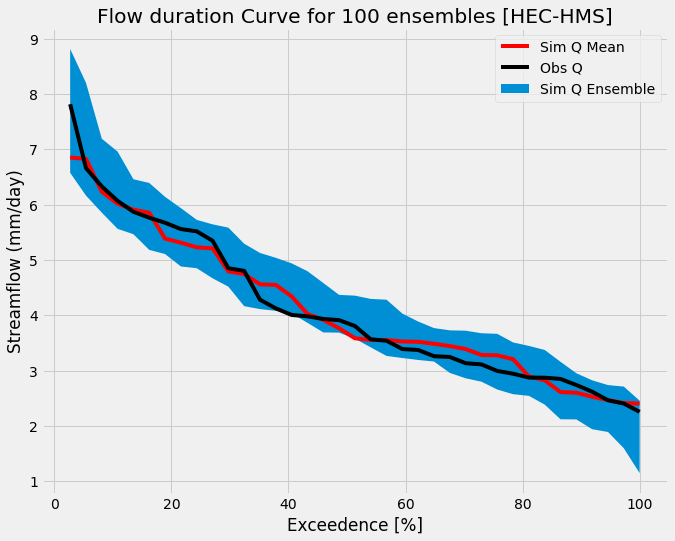

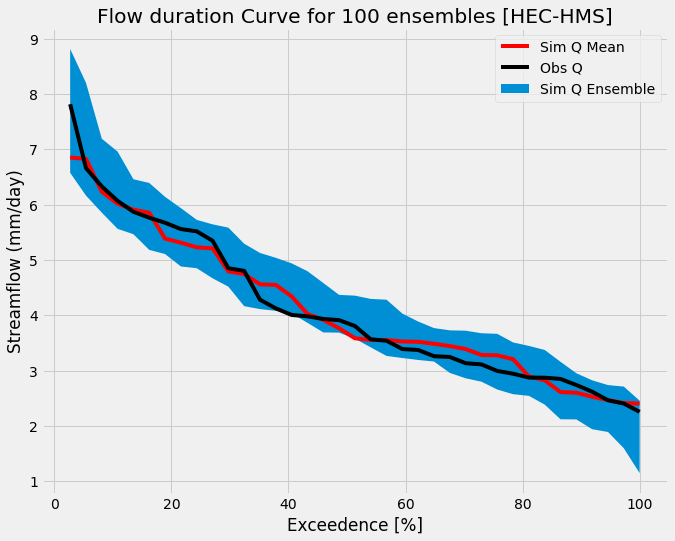

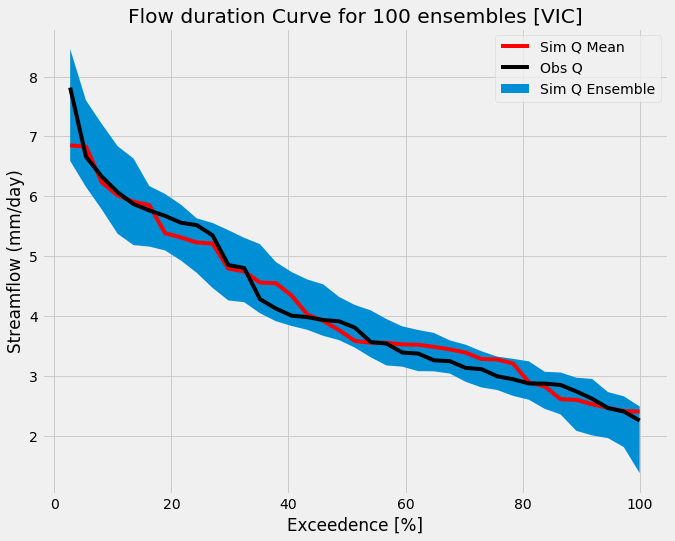

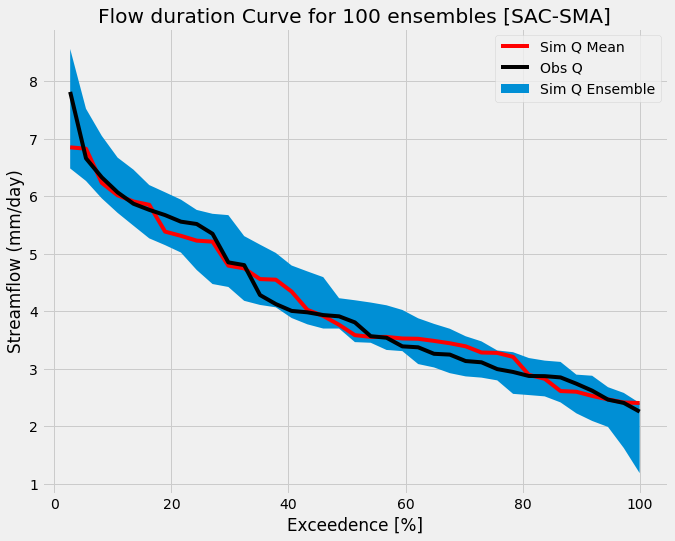

In [204]:
plotfdc(hechmsq, meanqdat, qobs,'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [HEC-HMS]', 'figures/fdcprms.png')
plotfdc(hechmsq, meanqdat, qobs, 'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [HEC-HMS]', 'figures/fdchechms.png')
plotfdc(vicq, meanqdat, qobs, 'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [VIC]', 'figures/fdcvic.png')
plotfdc(sacsmaq, meanqdat, qobs, 'Streamflow (mm/day)', 'Flow duration Curve for 100 ensembles [SAC-SMA]', 'figures/fdcsacsma.png')

# YEARLY PEAK FLOWS

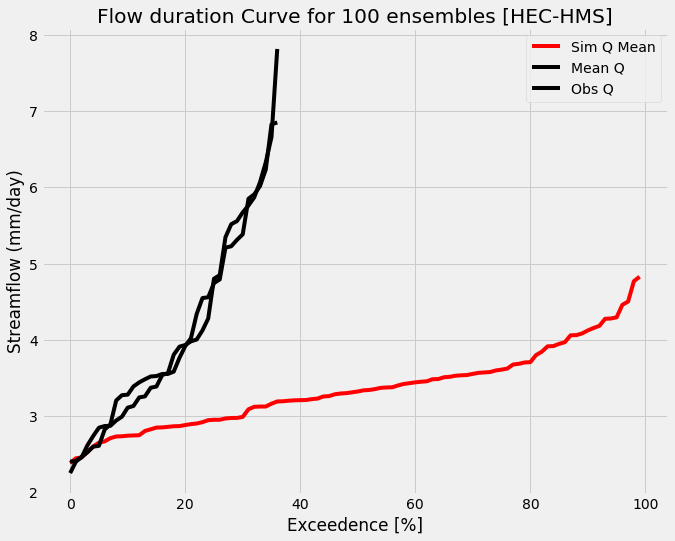

In [221]:
def plotpeakq(qdat, qmeandat, obsdat, pylabel, ptitle, psave):
    '''
    Calculates and plot exceedances of FUSE model outputs
    '''
    
    # Plot
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,8))
    #plt.fill_between(np.sort(qdat), np.min(qdat, axis=1),np.max(qdat, axis=1), label = "Sim Q Ensemble")
    plt.plot(np.sort(qdat[1]), label = 'Sim Q Mean', color='red')
    plt.plot(np.sort(qmeandat), label = 'Mean Q', color='black')
    plt.plot(np.sort(qobs), label = 'Obs Q', color='black')
    plt.xlabel("Exceedence [%]")
    plt.ylabel(pylabel)
    plt.title(ptitle)
    plt.legend()
    plt.savefig(psave, bbox_inches='tight', dpi=300)
    plt.show()

plotpeakq(hechmsq, meanqdat, qobs,'Streamflow (mm/day)', 
          'Flow duration Curve for 100 ensembles [HEC-HMS]', 'figures/fdcprms.png')